# EDA - Fake Reviews

In [1]:
import os
import ast
import csv
import torch
import numpy as np
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from transformers import pipeline

In [2]:
#Set directory
# os.chdir('/home/bleiva/capp30255/how_the_bear_got_a_C')

In [3]:
#Load data (if running locally)
# train = pd.read_csv('data/fake_reviews/train.csv')
# test = pd.read_csv('data/fake_reviews/test.csv')
# val = pd.read_csv('data/fake_reviews/val.csv')
# data = pd.concat([train, test, val], ignore_index=True)
# data.to_csv('eda/fake_reviews_eda.csv', index=False)

# Upload input file (if run in colab)
uploaded = files.upload()

Saving fake_reviews_eda.csv to fake_reviews_eda.csv


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
filename = 'fake_reviews_eda.csv'

# Load data
data = pd.read_csv(filename)
data.head()

,text,label,source,num_shot
0,"I recently dined at Estia and I must say, it w...",FAKE,gpt-3.5-turbo-16k-0613,zero
1,Stayed here for three nights. Front desk staff...,HUMAN,Yelp,0
2,I think I actually grew up with this movie the...,HUMAN,Yelp,0
3,I recently visited Burger King and unfortunate...,FAKE,gpt-3.5-turbo-16k-0613,zero
4,This restaurant presents itself as an upscale ...,HUMAN,Yelp,0


In [10]:
#Create length
data['text_length'] = data['text'].apply(len)

#Data Wrangling
column_to_replace = 'label'
column_sum1 = 'source'
column_sum2 = 'num_shot'
value_to_replace = 'FAKE'
for index, row in data.iterrows():
    if row[column_to_replace] == value_to_replace:
        sum_value = row[column_sum1] + row[column_sum2]
        data.at[index, column_to_replace] = sum_value
data['label'] = data['label'].replace({
    'gpt-3.5-turbo-16k-0613few': 'GPT-3.5, few-shot',
    'gpt-4-1106-previewfew': 'GPT-4, few-shot',
    'gpt-3.5-turbo-16k-0613zero': 'GPT-3.5, zero-shot'
})
data.head()

,text,label,source,num_shot,text_length
0,"I recently dined at Estia and I must say, it w...","GPT-3.5, zero-shot",gpt-3.5-turbo-16k-0613,zero,886
1,Stayed here for three nights. Front desk staff...,HUMAN,Yelp,0,736
2,I think I actually grew up with this movie the...,HUMAN,Yelp,0,1237
3,I recently visited Burger King and unfortunate...,"GPT-3.5, zero-shot",gpt-3.5-turbo-16k-0613,zero,498
4,This restaurant presents itself as an upscale ...,HUMAN,Yelp,0,1120


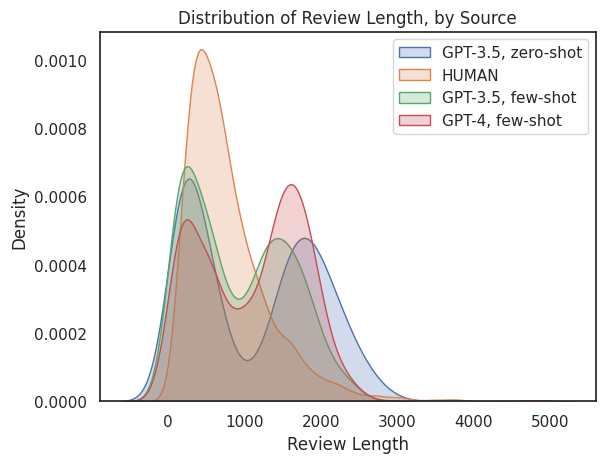

In [11]:
#Plot review distributions, by source
sns.set(style="white")
unique_labels = data['label'].unique()
for label in unique_labels:
    sns.kdeplot(data=data[data['label'] == label]['text_length'], label=label, fill=True)
plt.xlabel("Review Length")
plt.ylabel("Density")
plt.title("Distribution of Review Length, by Source")
plt.legend(title='', loc='upper right')
plt.show()

# Sentiment Analysis

In [21]:
def analyze_sentiments(df, sentiment_pipeline):
    """
    Takes reviews from inspected restaurant and associates them with 'positive'
    or 'negative' sentiment.

    Returns the same dataframe but with an extra column 'sentiment'.
    """
    sentiment_str_per_row = list()
    sentiment_int_per_row = list()

    # Output replacements
    output_to_str = {'1 star': 'negative', '2 stars': 'negative', '3 stars': 'neutral', '4 stars': 'positive', '5 stars': 'positive'}
    output_to_int = {'1 star': 1, '2 stars': 2, '3 stars': 3, '4 stars': 4, '5 stars': 5}

    # Apply sentiment analysis to each row
    for index, row in df.iterrows():
        if index % 44 == 0:
            print(f'progress: {round((index+1)/len(df)*100, 3)}%')

        # Sentiment analysis on the text in the 'text' column
        sentiment = sentiment_pipeline(row['text'][:512])[0]['label']

        # Convert sentiment label to 'positive', 'negative', or 'neutral'
        sentiment_str = output_to_str[sentiment]
        sentiment_int = output_to_int[sentiment]

        # Append sentiment to the lists
        sentiment_str_per_row.append(sentiment_str)
        sentiment_int_per_row.append(sentiment_int)

    # Add sentiment columns to the DataFrame
    df['sentiment_str'] = sentiment_str_per_row
    df['sentiment_int'] = sentiment_int_per_row

    return df

In [22]:
data.head()

,text,label,source,num_shot,text_length
0,"I recently dined at Estia and I must say, it w...","GPT-3.5, zero-shot",gpt-3.5-turbo-16k-0613,zero,886
1,Stayed here for three nights. Front desk staff...,HUMAN,Yelp,0,736
2,I think I actually grew up with this movie the...,HUMAN,Yelp,0,1237
3,I recently visited Burger King and unfortunate...,"GPT-3.5, zero-shot",gpt-3.5-turbo-16k-0613,zero,498
4,This restaurant presents itself as an upscale ...,HUMAN,Yelp,0,1120


In [14]:
#Set sentiment pipeline
task = "text-classification"
model = "nlptown/bert-base-multilingual-uncased-sentiment"
sentiment_pipeline = pipeline(task, model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [25]:
#Find review sentiments
data = analyze_sentiments(data, sentiment_pipeline)

progress: 0.015%
progress: 0.681%
progress: 1.347%
progress: 2.013%
progress: 2.679%
progress: 3.345%
progress: 4.011%
progress: 4.677%
progress: 5.343%
progress: 6.009%
progress: 6.675%
progress: 7.341%
progress: 8.007%
progress: 8.673%
progress: 9.339%
progress: 10.005%
progress: 10.671%
progress: 11.336%
progress: 12.002%
progress: 12.668%
progress: 13.334%
progress: 14.0%
progress: 14.666%
progress: 15.332%
progress: 15.998%
progress: 16.664%
progress: 17.33%
progress: 17.996%
progress: 18.662%
progress: 19.328%
progress: 19.994%
progress: 20.66%
progress: 21.326%
progress: 21.992%
progress: 22.658%
progress: 23.324%
progress: 23.99%
progress: 24.656%
progress: 25.322%
progress: 25.988%
progress: 26.654%
progress: 27.32%
progress: 27.985%
progress: 28.651%
progress: 29.317%
progress: 29.983%
progress: 30.649%
progress: 31.315%
progress: 31.981%
progress: 32.647%
progress: 33.313%
progress: 33.979%
progress: 34.645%
progress: 35.311%
progress: 35.977%
progress: 36.643%
progress: 37.

In [26]:
data.head()

,text,label,source,num_shot,text_length,sentiment_str,sentiment_int
0,"I recently dined at Estia and I must say, it w...","GPT-3.5, zero-shot",gpt-3.5-turbo-16k-0613,zero,886,positive,5
1,Stayed here for three nights. Front desk staff...,HUMAN,Yelp,0,736,positive,4
2,I think I actually grew up with this movie the...,HUMAN,Yelp,0,1237,positive,5
3,I recently visited Burger King and unfortunate...,"GPT-3.5, zero-shot",gpt-3.5-turbo-16k-0613,zero,498,negative,2
4,This restaurant presents itself as an upscale ...,HUMAN,Yelp,0,1120,neutral,3


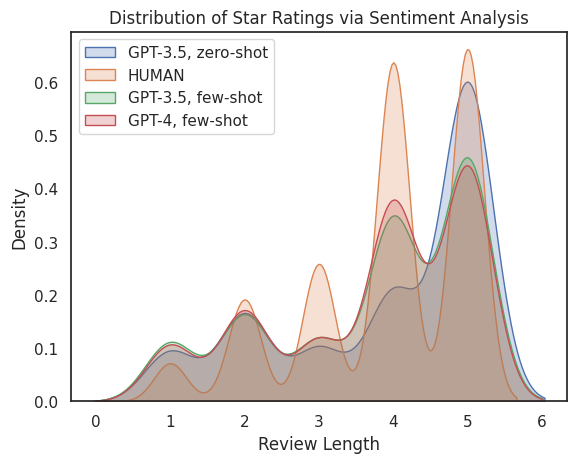

In [28]:
#Plot review distributions, by source
sns.set(style="white")
unique_labels = data['label'].unique()
for label in unique_labels:
    sns.kdeplot(data=data[data['label'] == label]['sentiment_int'], label=label, fill=True)
plt.xlabel("Review Length")
plt.ylabel("Density")
plt.title("Distribution of Star Ratings via Sentiment Analysis")
plt.legend(title='', loc='upper left')
plt.show()